# SetUp

In [1]:
# LOAD LIBRARIES
suppressPackageStartupMessages(library(tictoc))
tic("LIBRARIES")
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(future))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(presto))
suppressPackageStartupMessages(library(cowplot))

suppressPackageStartupMessages(library(enrichR))
suppressPackageStartupMessages(library(org.Hs.eg.db))
suppressPackageStartupMessages(library(AnnotationDbi))

suppressPackageStartupMessages(library(SingleR))

suppressPackageStartupMessages(library(GPTCelltype))
suppressPackageStartupMessages(library(openai))
toc()

LIBRARIES: 7.294 sec elapsed


In [2]:
total_time <- function(seconds) {
    d <- seconds %/% (86400)
    h <- (seconds %% 86400) %/% 3600
    m <- (seconds %% 3600) %/% 60
    s <- seconds %% 60
    
    cat(sprintf("Total Time: %f Days, %f Hours, %f Minutes and %f Seconds\n", d, h, m, s))
}

# Note

* Subcluster di neuroni e simili
* Mesi: 1, 2, 3
* Geni:
    * SRCIN1
    * SATB2 (manca nel KO di p140)

# Name

In [3]:
timepoints = c("1month", "2month", "3month")
genes_of_interest = c("SRCIN1", "SATB2")
path_to_data = "/sharedFolder/Data/"
res = c(1, 0.5)
n_dim = c(1:20)

In [37]:
timepoint <- timepoints[3]

# Clustering

In [38]:
tic()

In [39]:
# Load the data
tic()
raw_data <- Read10X(data.dir = paste(path_to_data, "expression_", timepoint, sep = ""), gene.column = 1)
toc()

73.662 sec elapsed


In [40]:
# Create Seurat object
tic()
sc_data <- CreateSeuratObject(counts = raw_data, min.cells = 3, min.features = 500, project = timepoint, names.delim = "-", names.field = 2)
toc()

Warning message:
“Input parameters result in NA values for initial cell identities. Setting all initial idents to the project name”


15.857 sec elapsed


In [41]:

tic()
mito.genes <- grep(pattern = "^MT-", x = rownames(x = sc_data), value = TRUE)
percent.mito <- Matrix::colSums(GetAssayData(sc_data, slot='counts')[mito.genes, ]) / Matrix::colSums(GetAssayData(sc_data, slot="counts"))
sc_data[['percent.mito']] <- percent.mito
ribo.genes <- grep("^RP[S,L]",rownames(sc_data), value = TRUE)
percent.ribo <- Matrix::colSums(GetAssayData(sc_data, slot='counts')[ribo.genes, ]) / Matrix::colSums(GetAssayData(sc_data, slot="counts"))
sc_data[['percent.ribo']] <- percent.ribo
pdf(paste0(getwd(),'/QC_Rplots.pdf'))
par(mfrow = c(1, 3))
print(FeatureScatter(object = sc_data, feature1 = "nCount_RNA", feature2 = "percent.mito"))
print(FeatureScatter(object = sc_data, feature1 = "nCount_RNA", feature2 = "percent.ribo"))
print(FeatureScatter(object = sc_data, feature1 = "nCount_RNA", feature2 = "nFeature_RNA"))
dev.off()
toc()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



agg_record_1616103271 
                    2

11.417 sec elapsed


In [42]:
# Normalize the data
tic()
sc_data <- NormalizeData(sc_data, normalization.method = "LogNormalize", scale.factor = 1e6)
toc()

Normalizing layer: counts



15.647 sec elapsed


In [43]:
# Find variable features
tic()
sc_data <- FindVariableFeatures(sc_data, selection.method = "mvp")
toc()

Finding variable features for layer data



20.265 sec elapsed


In [44]:
print("Regress out!")
tic()
sc_data = CellCycleScoring(sc_data, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes)
sc_data$CC.Difference <- sc_data$S.Score - sc_data$G2M.Score
toc()

[1] "Regress out!"


Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”


9.958 sec elapsed


In [45]:
# Scale the data
tic()
sc_data<-ScaleData(sc_data,features=VariableFeatures(sc_data),vars.to.regress=c("nCount_RNA","CC.Difference"))
toc()

Regressing out nCount_RNA, CC.Difference

Centering and scaling data matrix



146.461 sec elapsed


In [46]:
?RunUMAP

RunUMAP {Seurat},R Documentation
object,An object
...,Arguments passed to other methods and UMAP
reduction.key,"dimensional reduction key, specifies the string before the number for the dimension names. UMAP by default"
assay,"Assay to pull data for when using features, or assay used to construct Graph if running UMAP on a Graph"
reduction.model,DimReduc object that contains the umap model
return.model,whether UMAP will return the uwot model
umap.method,UMAP implementation to run. Can be uwot:Runs umap via the uwot R package uwot-learn:Runs umap via the uwot R package and return the learned umap model umap-learn:Run the Seurat wrapper of the python umap-learn package
n.neighbors,This determines the number of neighboring points used in local approximations of manifold structure. Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range 5 to 50.
n.components,The dimension of the space to embed into.
metric,"metric: This determines the choice of metric used to measure distance in the input space. A wide variety of metrics are already coded, and a user defined function can be passed as long as it has been JITd by numba."


In [47]:
# PCA
tic()
sc_data <- RunPCA(sc_data, npcs = max(n_dim), verbose = T)
sc_data <- RunUMAP(sc_data, dims = n_dim, verbose = T)
toc()

PC_ 1 
Positive:  SOX2, PON2, ANXA5, ZFP36L1, HES1, CLU, HOPX, SLC1A3, SPARC, BCAN 
	   CD99, SOX3, PAX6, HSPB1, EMP3, ID4, HTRA1, ID3, SOX9, CD9 
	   PTN, PHGDH, METRN, IQGAP2, PLPP3, RCN1, PBK, ZFP36L2, C8orf4, F3 
Negative:  NEUROD2, NEUROD6, NELL2, SYT1, ARPP21, SLA, MEF2C, LINGO1, SNCA, SOX4 
	   SNAP25, CSRP2, GRIN2B, SCD5, CELF4, GPR22, GRIA2, PLK2, FGF12, BHLHE22 
	   IGSF21, C11orf96, EEF1A2, ZEB2, SLC17A7, SERPINI1, SYT4, SYBU, BRINP1, RNF165 
PC_ 2 
Positive:  DDIT4, ADM, DDIT3, TUBA4A, P4HA1, STC2, CEBPB, FAM162A, SNHG8, FTL 
	   BNIP3, NUPR1, ALDOA, HERPUD1, NEAT1, SLC16A3, CDKN1A, SELM, ALDOC, CTA-29F11.1 
	   P4HB, HILPDA, ANGPTL4, TMEM45A, BHLHE40, MFSD2A, ARF4, DNAJB9, IGFBP5, ANKRD37 
Negative:  RRM2, MT-ND3, MT-ND1, MKI67, MTRNR2L8, PBK, SPC25, TOP2A, ZWINT, MYBL2 
	   NUSAP1, NUF2, MT-ND2, MTRNR2L10, SGOL1, MTRNR2L12, FAM64A, CENPU, MT-ND5, AURKB 
	   CCNA2, NDC80, BIRC5, CDK1, ASPM, DLGAP5, UBE2C, KIAA0101, TACC3, CENPF 
PC_ 3 
Positive:  VSNL1, NUF2, PBK, MKI67, R

116.951 sec elapsed


In [48]:
# Cluster the cells
tic()
sc_data <- FindNeighbors(sc_data, dims = n_dim, verbose = T)
sc_data <- FindClusters(sc_data, resolution = 1, verbose = T)
toc()

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 159533
Number of edges: 4722250

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8896
Number of communities: 32
Elapsed time: 44 seconds
76.565 sec elapsed


In [49]:
# print("Save object!")
# saveRDS(sc_data, file = paste0(outdir,"initial_sc_data.rds"))
tic()

pdf(paste0(getwd(),'/pca_Rplots.pdf'))
print(VizDimLoadings(object = sc_data, dims = 1:2))
print(DimPlot(object = sc_data))
DimHeatmap(object = sc_data, dims = 1:9, cells = 500, balanced = TRUE)
print(ElbowPlot(object = sc_data, 30))
dev.off()
toc()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message in ElbowPlot(object = sc_data, 30):
“The object only has information for 20 reductions”


agg_record_753431014 
                   2

1.047 sec elapsed


In [50]:
cluster.plot <- function(
    data,
    file_name = timepoints[time_point],
    pt.size = 1,
    print_plot = F
) { 
    plots <- list(
        UMAP = DimPlot(data, reduction = "umap", label = TRUE, pt.size = pt.size) + 
            ggtitle(paste("UMAP -",file_name)),
        PCA = DimPlot(data, reduction = "pca", label = TRUE, pt.size = pt.size) + 
            ggtitle(paste("PCA -",file_name))
    )

    if (print_plot) {print(plots)}
    
    return(plots)
}

In [51]:
tic()

cluster_plots <- cluster.plot(
    sc_data,
    file_name = timepoint,
    pt.size = 0.5,
    print_plot = F
)
toc()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



0.702 sec elapsed


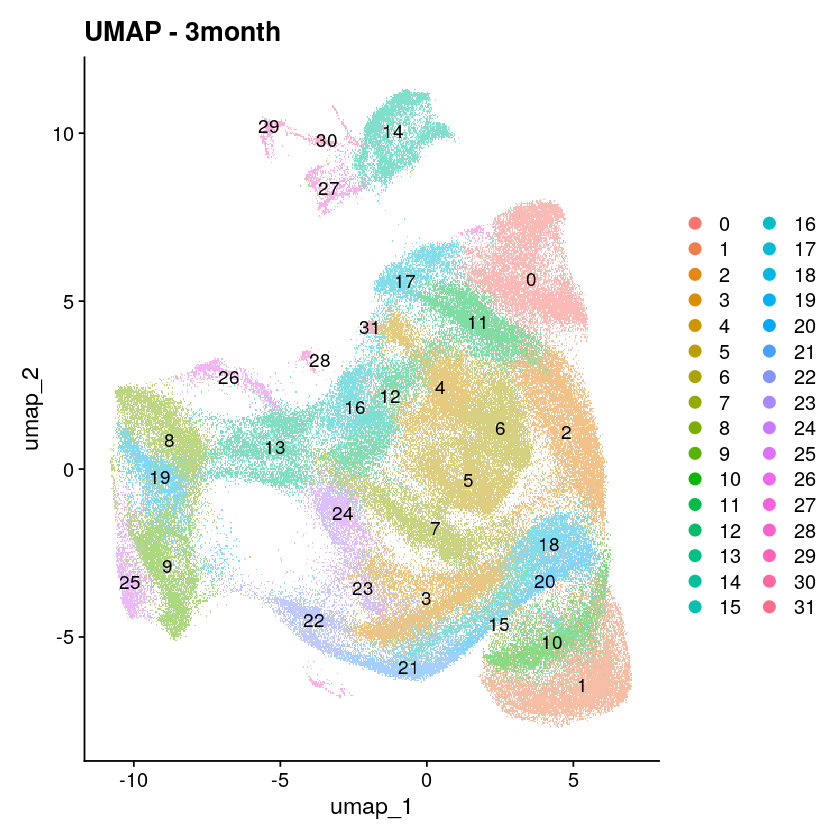

In [52]:
cluster_plots[[1]]

In [53]:
table(Idents(sc_data))
nrow(sc_data@meta.data)
head(sc_data@meta.data)


    0     1     2     3     4     5     6     7     8     9    10    11    12 
12396 12379 11536  8944  8226  7732  7661  7489  6503  6297  6164  6090  5998 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
 5934  5851  4409  4038  3875  3677  3636  3534  3344  3186  2361  2348  1938 
   26    27    28    29    30    31 
 1131   944   622   557   437   296 

[1] 159533

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,percent.ribo,S.Score,G2M.Score,Phase,CC.Difference,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<fct>
1_AAACCTGAGCAATATG_1_3m,3month,6908,2852,0.006658946,0.1191372,-0.23065248,-0.32744449,G1,0.09679200,7,7
1_AAACCTGAGCCAGTTT_1_3m,3month,1649,758,0.098847787,0.2983626,-0.04195253,-0.29450074,G1,0.25254821,15,15
1_AAACCTGAGTCCATAC_1_3m,3month,1916,982,0.079331942,0.2155532,0.08663236,-0.09079064,S,0.17742301,8,8
1_AAACCTGAGTGACTCT_1_3m,3month,5488,2463,0.021865889,0.1206268,-0.44750057,-0.26684897,G1,-0.18065160,10,10
1_AAACCTGAGTGCCAGA_1_3m,3month,3167,1344,0.041679823,0.2393432,-0.20456164,-0.13265628,G1,-0.07190536,2,2
1_AAACCTGAGTGGCACA_1_3m,3month,1806,1053,0.007751938,0.1212625,-0.13047532,0.15988964,G2M,-0.29036496,11,11


In [54]:
# Find all markers for every cluster compared to all remaining cells
tic()
cluster_markers <- FindAllMarkers(sc_data,
                          only.pos = TRUE,   # Considera solo i marker espressi positivamente
                          min.pct = 0.25,    # Percentuale minima di espressione nelle cellule del cluster
                          logfc.threshold = 0.25,  # Soglia minima di LogFC
                          verbose = T)
summary(cluster_markers)
head(cluster_markers)
toc()

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31



     p_val             avg_log2FC         pct.1            pct.2       
 Min.   :0.000e+00   Min.   :0.2500   Min.   :0.1160   Min.   :0.0010  
 1st Qu.:0.000e+00   1st Qu.:0.3982   1st Qu.:0.3180   1st Qu.:0.1820  
 Median :0.000e+00   Median :0.6044   Median :0.4250   Median :0.2690  
 Mean   :3.771e-05   Mean   :0.8549   Mean   :0.4925   Mean   :0.3367  
 3rd Qu.:0.000e+00   3rd Qu.:0.9789   3rd Qu.:0.6210   3rd Qu.:0.4330  
 Max.   :9.883e-03   Max.   :9.7658   Max.   :1.0000   Max.   :0.9970  
                                                                       
   p_val_adj         cluster          gene          
 Min.   :0.0000   18     : 2003   Length:29978      
 1st Qu.:0.0000   20     : 1799   Class :character  
 Median :0.0000   1      : 1780   Mode  :character  
 Mean   :0.0228   9      : 1488                     
 3rd Qu.:0.0000   19     : 1315                     
 Max.   :1.0000   26     : 1287                     
                  (Other):20306                     

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
NTS,0,3.185308,0.428,0.057,0,0,NTS
MYC,0,1.940870,0.475,0.172,0,0,MYC
FAM215B,0,1.576735,0.513,0.216,0,0,FAM215B
RPL36A,0,1.392080,0.939,0.583,0,0,RPL36A
MORN4,0,1.380178,0.337,0.160,0,0,MORN4
PET100,0,1.322538,0.572,0.285,0,0,PET100


622.197 sec elapsed


In [77]:
tic()
de_genes <- cluster_markers %>% filter(gene %in% genes_of_interest) %>% arrange(avg_log2FC) %>% filter(p_val_adj < 0.05 & avg_log2FC > 0.6) 
de_genes
toc()

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SRCIN13,3.967343e-173,0.7195766,0.309,0.132,1.078959e-168,20,SRCIN1
SATB2,5.560705e-216,0.7789023,0.354,0.239,1.512289e-211,0,SATB2
SATB23,1.421291e-298,0.8305278,0.427,0.239,3.865344e-294,6,SATB2
SRCIN11,1.151617e-225,0.8527618,0.250,0.129,3.131938e-221,3,SRCIN1
SRCIN1,0.000000e+00,0.9720746,0.260,0.125,0.000000e+00,1,SRCIN1
SATB22,0.000000e+00,1.0916678,0.480,0.234,0.000000e+00,3,SATB2
SRCIN12,0.000000e+00,1.1551603,0.383,0.130,0.000000e+00,18,SRCIN1
SATB21,0.000000e+00,1.1566471,0.554,0.224,0.000000e+00,2,SATB2
SATB26,0.000000e+00,1.9336170,0.812,0.235,0.000000e+00,20,SATB2


0.01 sec elapsed


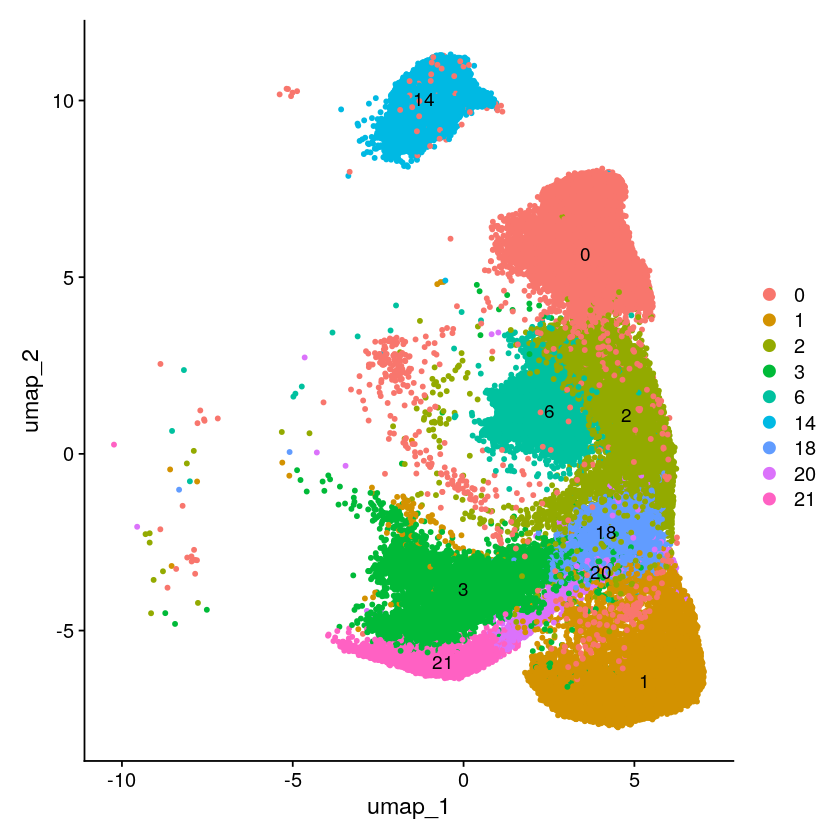

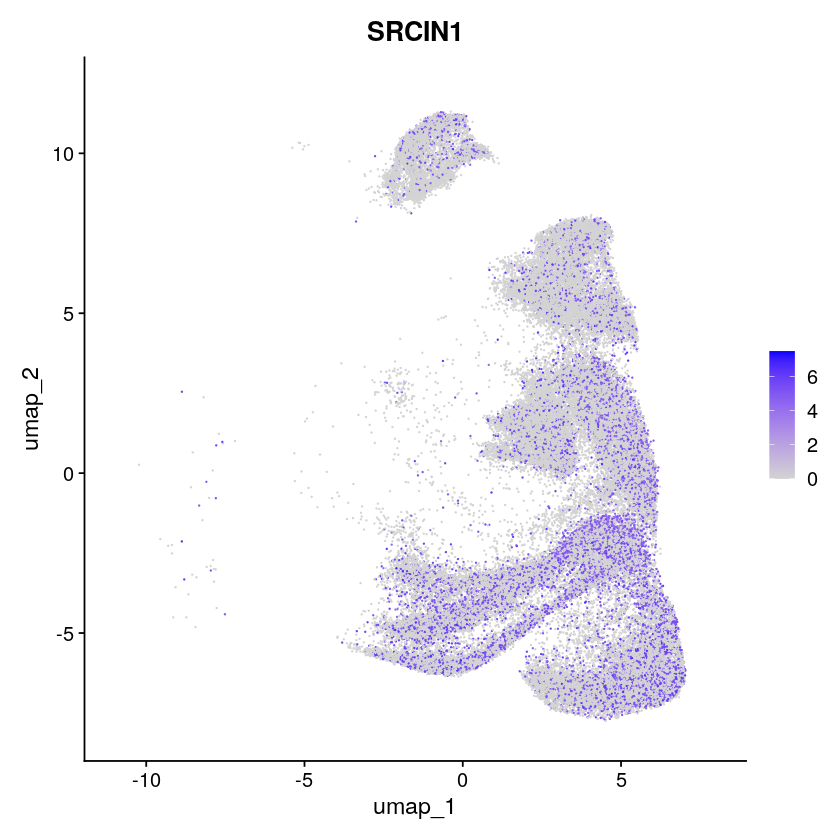

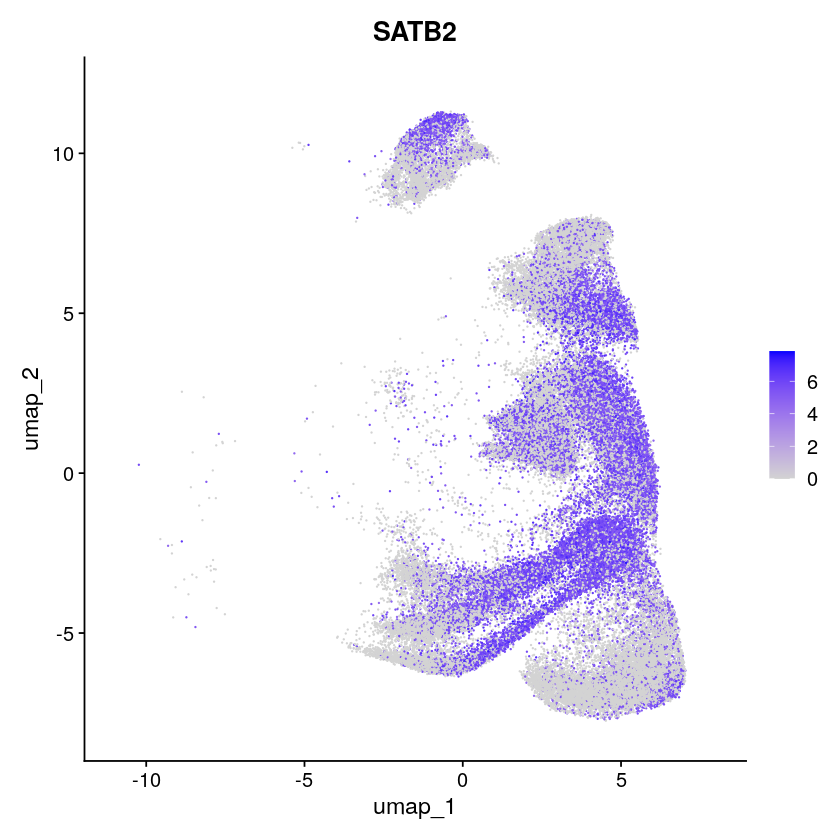

In [71]:
filtered_obj <- subset(sc_data, subset = seurat_clusters %in% de_genes$cluster)
DimPlot(filtered_obj, reduction = "umap", label = TRUE, pt.size = 1)
FeaturePlot(filtered_obj, genes_of_interest[1])
FeaturePlot(filtered_obj, genes_of_interest[2])

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



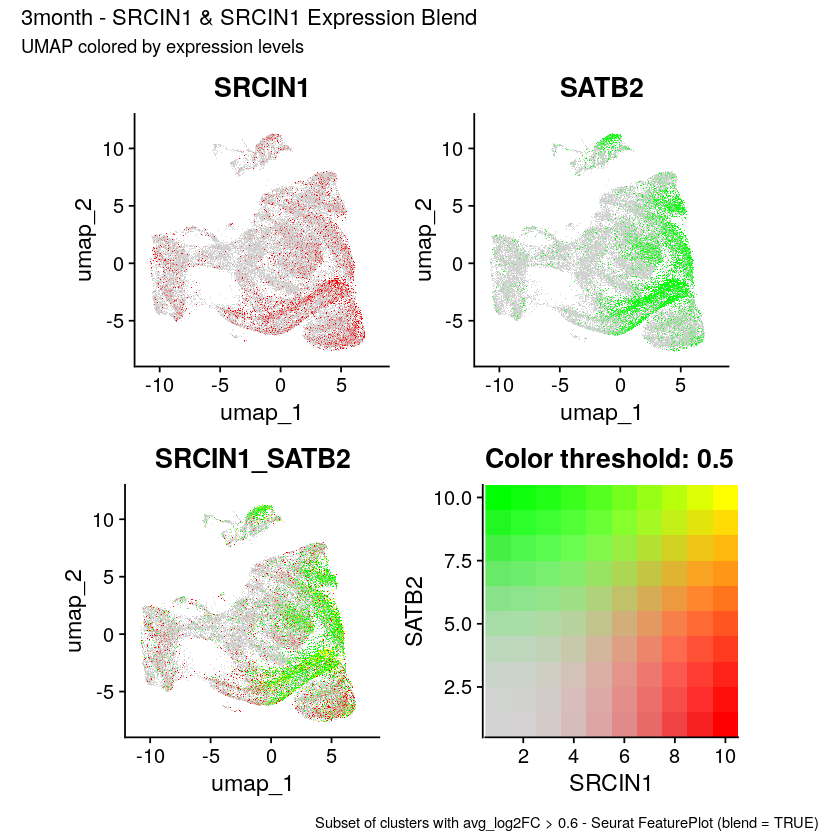

In [109]:
library(patchwork)
plot_blend <- FeaturePlot(sc_data, features = genes_of_interest, blend = T, ncol = 2) &
  theme(aspect.ratio = 1)
plot_blend <- (plot_blend[[1]] | plot_blend[[2]]) /
              (plot_blend[[3]] | plot_blend[[4]]) +
              plot_annotation(
                title = paste(timepoint, "-", genes_of_interest[1], "&", genes_of_interest[1], "Expression Blend"),
                subtitle = "UMAP colored by expression levels",
                caption = "Subset of clusters with avg_log2FC > 0.6 - Seurat FeaturePlot (blend = TRUE)"
              )

plot_blend

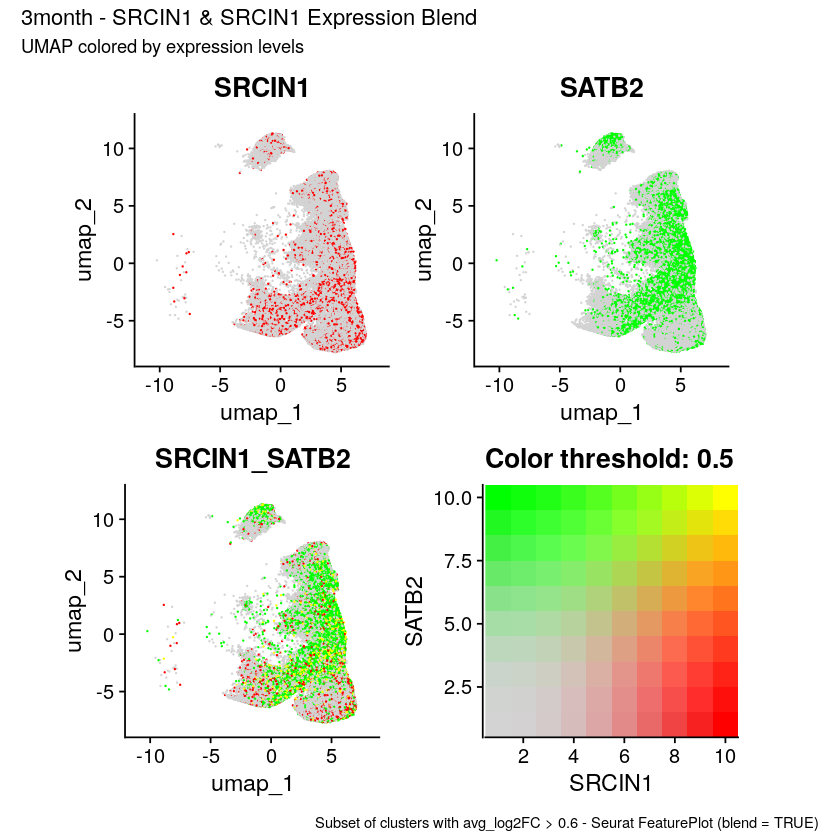

In [110]:
library(patchwork)
plot_blend <- FeaturePlot(filtered_obj, features = genes_of_interest, blend = T, ncol = 2) &
  theme(aspect.ratio = 1)
plot_blend <- (plot_blend[[1]] | plot_blend[[2]]) /
              (plot_blend[[3]] | plot_blend[[4]]) +
              plot_annotation(
                title = paste(timepoint, "-", genes_of_interest[1], "&", genes_of_interest[1], "Expression Blend"),
                subtitle = "UMAP colored by expression levels",
                caption = "Subset of clusters with avg_log2FC > 0.6 - Seurat FeaturePlot (blend = TRUE)"
              )

plot_blend

In [108]:
ggsave(
    filename = "plot_blend.png",
    plot = plot_blend,
    ,  width = 1920*2, height = 1920*2, units = "px"
)

In [82]:
12396+ 12379 +11536 + 8944  +7661  +5851 + 3677 + 3534 + 3344 ==nrow(filtered_obj@meta.data)

[1] TRUE

In [84]:
table(Idents(filtered_obj))
nrow(filtered_obj@meta.data)
nrow(filtered_obj@meta.data)/nrow(sc_data@meta.data) *100


    0     1     2     3     6    14    18    20    21 
12396 12379 11536  8944  7661  5851  3677  3534  3344 

[1] 69322

[1] 43.45308

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



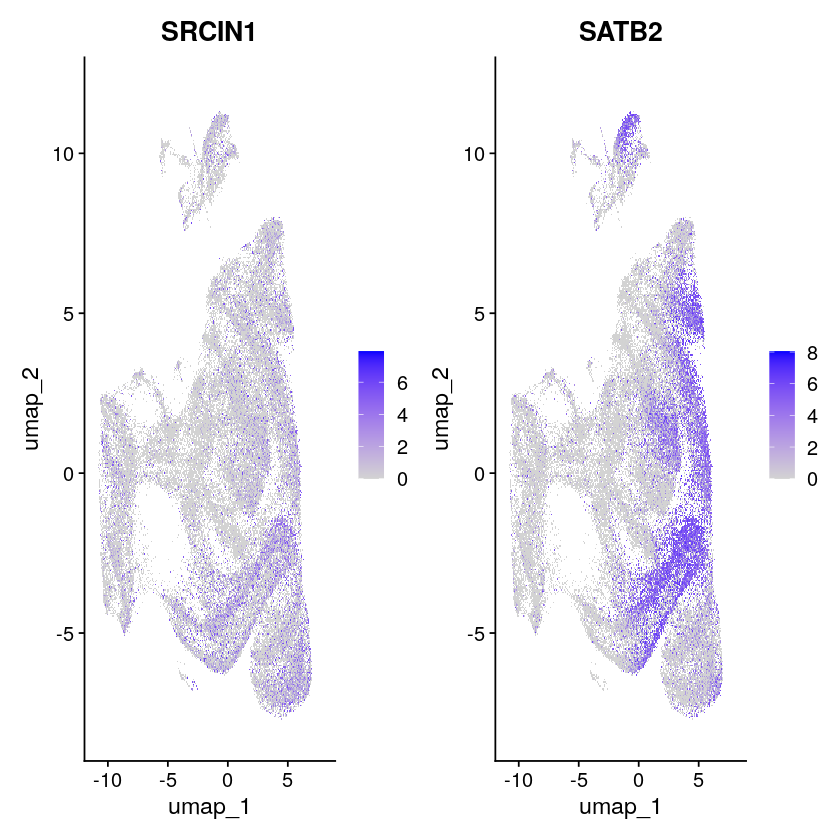

In [56]:
FeaturePlot(sc_data, c(genes_of_interest))

In [57]:
tic()
ggsave(
    filename = "plot.png",
    plot = FeaturePlot(sc_data, c(genes_of_interest)),
    ,  width = 1920, height = 1080, units = "px"
)
toc()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



1.549 sec elapsed


In [58]:
toc()

1115.271 sec elapsed


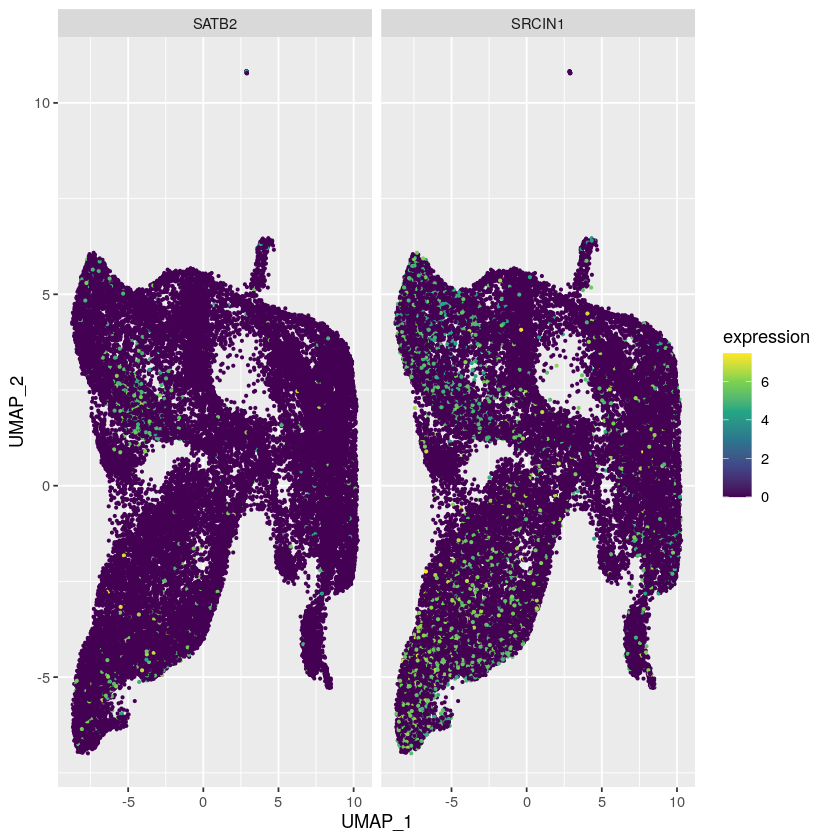

In [25]:
# Get UMAP coordinates
umap <- Embeddings(sc_data, reduction = "umap")

# Get expression values for your genes
expr <- FetchData(sc_data, vars = genes_of_interest)

# Combine them into one data frame
expr$UMAP_1 <- umap[,1]
expr$UMAP_2 <- umap[,2]

# Reshape for ggplot
library(tidyr)

expr_long <- pivot_longer(expr, all_of(genes_of_interest),
                          names_to = "gene", values_to = "expression")

# Plot with shared scale
ggplot(expr_long, aes(UMAP_1, UMAP_2, color = expression)) +
  geom_point(size = 0.5) +
  scale_color_viridis_c() +
  facet_wrap(~gene)   # if you still want facets, but on the same scale

# Cell Annotation

## signac

In [26]:
library(signac)

ERROR: Error in library(signac): there is no package called ‘signac’


## SingeR

In [2]:
library(SingleR)

In [ ]:
BiocManager::install("zellkonverter")
library(zellkonverter)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



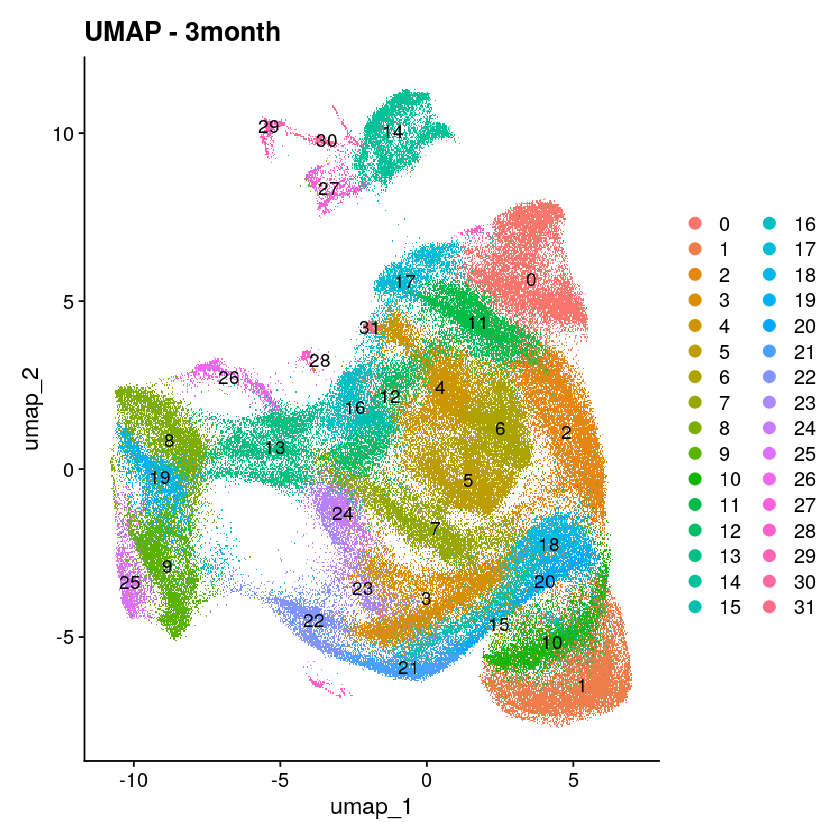

In [116]:
DimPlot(sc_data, reduction = "umap", label = TRUE, pt.size = 1) + 
            ggtitle(paste("UMAP -",timepoint))

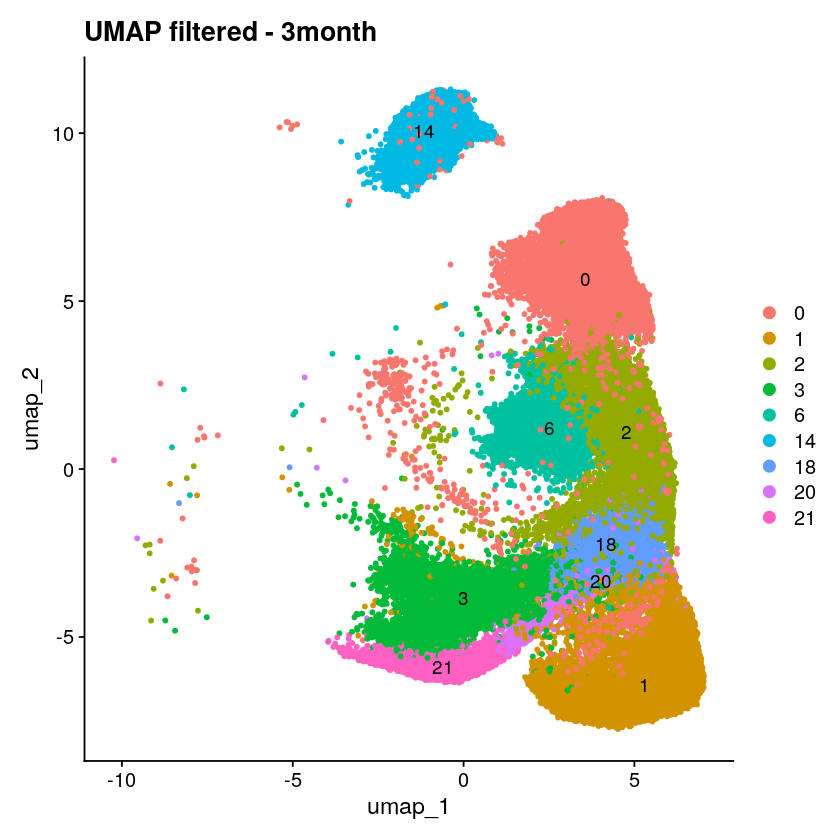

In [118]:
DimPlot(filtered_obj, reduction = "umap", label = TRUE, pt.size = 1) + 
            ggtitle(paste("UMAP filtered -",timepoint))

### HumanPrimaryCellAtlasData

In [6]:
ref <- celldex::HumanPrimaryCellAtlasData()

ERROR: [1m[33mError[39m in `collect()`:[22m
[1m[22m[33m![39m Failed to collect lazy table.
[1mCaused by error in `db_collect()`:[22m
[1m[22m[33m![39m Arguments in `...` must be used.
[31m✖[39m Problematic argument:
[36m•[39m ..1 = Inf
[36mℹ[39m Did you misspell an argument name?


In [129]:
summary(ref)

ERROR: Error in object[[i]]: object of type 'closure' is not subsettable


In [ ]:
results <- SingleR(test = as.SingleCellExperiment(sc_data), ref = ref, labels = ref$)

### hnoca_cleanedmeta.h5ad

In [ ]:
ref <- readH5AD("SingleR_reference/hnoca_cleanedmeta.h5ad")

+ /root/.cache/R/basilisk/1.10.2/0/bin/conda 'create' '--yes' '--prefix' '/root/.cache/R/basilisk/1.10.2/zellkonverter/1.8.0/zellkonverterAnnDataEnv-0.8.0' 'python=3.8.13' '--quiet' '-c' 'conda-forge'



In [ ]:
summary(ref)

In [ ]:
ref
assayNames(ref)
colnames(colData(ref))


In [ ]:
head(colData(ref))


In [ ]:
results <- SingleR(test = as.SingleCellExperiment(sc_data), ref = ref, labels = ref$)

In [ ]:
summary(results)

In [ ]:
head(results)

# Subclustering and second annotation

# Differentially Expressed Genes